In [1]:
# import some libraries
import numpy as np
import pandas as pd

from scipy.stats import poisson

%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
#read a file
#df = pd.read_excel("C:/Users/Admin/Pythonprojects/RAMS/data/CMMS_demodata.xlsx", index_col=0, header=0)   #for those who want to load a file from disk
df = pd.read_excel('https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/CMMS_demodata.xlsx', index_col=0, header=0) 
#dfcmms = pd.to_datetime(["2015-01-21","2016-04-14","2016-11-08","2016-12-01"])
dfcmms = pd.DataFrame(df,columns=["Notif.date"])
df

,Notifictn type,Description,Order,Functional Loc.,Created On,Notif.date,Reference date,Malfunct. start,Malfunct.end,Req. start,Required End,Priority,Completn date
Notification,,,,,,,,,,,,,
10336908,SO,Bestellingen t.b.v. BUBO afsluiters,40085158,x2,2015-01-21,2015-01-21,2017-02-14,2015-01-21,NaT,2015-01-21,2015-08-28,3-Medium,2017-02-14
10735688,SO,BESTELORDER LLI 3X ZEKOWA,40348131,x3,2016-04-14,2016-04-14,2017-02-14,2016-04-14,NaT,2016-04-14,NaT,3-Medium,2017-02-14
10979795,M1,1591 ZeKoWa P. BB + SB waaiers vervangen,40506403,x1_1591,2016-11-08,2016-11-08,2016-12-15,2016-11-08,2016-12-09,2016-11-08,2016-12-12,2-High,2016-12-15
11014798,SO,Voorbestelling LLI 3x Zekowa,40525236,x4,2016-12-01,2016-12-01,2018-07-04,2016-12-01,NaT,2016-12-01,2017-12-15,3-Medium,2018-07-04


In [41]:
# assess the arrival times
# the start/stop time of observing equal the first/last arrival by default, but they may be overruled manually

start = dfcmms["Notif.date"].min()      #default
start = pd.to_datetime("2015-01-01")    #manual overrule

stop = dfcmms["Notif.date"].max()       #default
stop = pd.to_datetime("2017-01-01")     #manual overrule

dfcmms["arrival"]=dfcmms["Notif.date"]-start
dfcmms["arrival"]

Notification
10336908    20 days
10735688   469 days
10979795   677 days
11014798   700 days
Name: arrival, dtype: timedelta64[ns]

In [42]:
# create a list of the arrivals times and counts

if (start == dfcmms["Notif.date"].min()):
    a_times = list(dfcmms["arrival"].dt.days)
    
    
else:
    a_times = list(dfcmms["arrival"].dt.days) + [0]
    

a_times.sort()
print(a_times)

a_count = list(range(len(a_times)))
print(a_count)

[0, 20, 469, 677, 700]
[0, 1, 2, 3, 4]


In [43]:
#estimate the MLE Poisson parameter

poismle = max(a_count)/(stop-start).days
print("mle MTTF: "+str(+1/poismle))


#eventually the experiment could be extended with an OLS estimation...

poisols = sum([i*j for (i, j) in zip(a_times, a_count)])/sum([i*j for (i, j) in zip(a_times, a_times)])
print("ols MTTF: "+str(+1/poisols))


pois = poismle

mle MTTF: 182.75
ols MTTF: 201.88115391259285


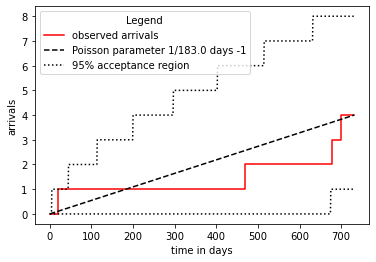

In [44]:

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1) # one row, one column, first plot

line, = ax1.step(a_times+[(stop-start).days],
         a_count+[max(a_count)],
         where="post",
        label="observed arrivals",
        color="red")

line, = ax1.plot(a_times+[(stop-start).days],
              [i * pois for i in a_times+[(stop-start).days]],
                label="Poisson parameter"+" 1/"+str(round(+1/pois,0))+" days -1",
                color="black",
                linestyle="dashed")

line, = ax1.plot(np.arange(0,(stop-start).days),
               poisson.ppf(0.025,np.arange(0,(stop-start).days)*pois),
                label="95% acceptance region",
                color="black",
                linestyle="dotted")

line, = ax1.plot(np.arange(0,(stop-start).days),
               poisson.ppf(0.975,np.arange(0,(stop-start).days)*pois),
                color="black",
                linestyle="dotted")

xtext = ax1.set_xlabel('time in days') # returns a Text instance
ytext = ax1.set_ylabel('arrivals')

plt.legend(title='Legend')
#plt.savefig("C:/Users/Chris/Pythonprojects/RAMS/figures/PoissonPlot01.png")
#plt.show()

